# What is IForest behavior according to the dataset dimension size?

## Test with 1 dimension dataset

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from matplotlib.mlab import frange
import statistics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from imblearn.metrics import specificity_score
from imblearn.metrics import sensitivity_score
import matplotlib.cm as cm
from mpl_toolkits import mplot3d
from imblearn.metrics import specificity_score
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

Using TensorFlow backend.


## Generals settings

In [2]:
datasets_path = '/Users/thesard/Doctorat/These2018/ISEP/Developpements/AnacondaWorkSpace/LearningPython/datasets/'

## Chargement du jeu de données

Le jeu de données artificiel généré suivant une distribution gaussienne.
Il s'agit d'un jeu de données univarié ou unidimensionnel contenant des données normales et anormales.
Les données normales suivent une distribution gaussienne de paramètres mu = 0 et sigma = 1.
Les données anormales suivent une distribution gaussienne de paramètres mu = 5 et de sigma = 1.

In [3]:
dataset_path = datasets_path+"synthetic_1D_data/synthetic_1D_data_2019-12-17 10:43:50.547607.csv"
dataset_brut = pd.read_csv(dataset_path, header=None, index_col=None)
dataset_number_dimension = len(dataset_brut.columns)
if dataset_number_dimension-2 == 0:
    X_brut_brut = dataset_brut[0]
elif dataset_number_dimension-2 > 0:
    X_brut_brut = dataset_brut[[0,dataset_number_dimension-2]]
else:
    print("There is an error in the dataset you uploaded. It have to have at least 2 columns.")
X_brut = pd.DataFrame(X_brut_brut)
y_brut = dataset_brut[dataset_number_dimension-1]
#y_brut = pd.DataFrame(y_brut_brut)
dataset_brut.describe()

,0
count,1516.000000
mean,0.032098
std,1.107025
min,-3.334118
25%,-0.692580
50%,-0.034028
75%,0.649778
max,6.867883


In [4]:
dataset_brut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516 entries, 0 to 1515
Data columns (total 2 columns):
0    1516 non-null float64
1    1516 non-null object
dtypes: float64(1), object(1)
memory usage: 23.8+ KB


In [20]:
abnormals_data = np.where(dataset_brut[dataset_number_dimension-1]=='0')
abnormals_data

(array([1501, 1502, 1503, 1504, 1505, 1506, 1507, 1508, 1509, 1510, 1511,
        1512, 1513, 1514, 1515]),)

## Transformation de la classe à expliquer

L'objectif ici est de remplacer les "0" par -1 et les "1" par 1 afin de faire les matrices de confusion avec la fonction dédiée de scikit-learn.

In [5]:
y_transform = y_brut
y_transform = np.where(y_transform=='0',-1,1)
y_transform

array([ 1,  1,  1, ..., -1, -1, -1])

## Execution of IForest on the dataset to see the high performance possible

In [6]:
specificities =[]
roc_aucs = []
# Instanciation, fit and predict on Shuttle
GENE_func_IF = IsolationForest(behaviour="new")
GENE_func_IF.fit(X_brut)
GENE_y_pred_IF = GENE_func_IF.predict(X_brut)
#print(GENE_y_pred_IF)
# Calcul de l'aire sous la courbe ROC
y_DF_IF = GENE_func_IF.decision_function(X_brut)

# Matrice de confusion
#ttn, tfp, tfn, ttp = confusion_matrix(y_transform_Shuttle, MS_y_pred_IF_Shuttle).ravel()
print(confusion_matrix(y_transform, GENE_y_pred_IF))
#ROC AUC
roc_aucs.append(roc_auc_score(y_transform, y_DF_IF))
# Specificity
specificities.append(specificity_score(y_transform, GENE_y_pred_IF))
print("ROC AUC")
print(roc_aucs)
print("Specificities")
print(specificities)
min_roc_auc = max(roc_aucs)
print("min_roc_auc = "+str(min_roc_auc))

/Users/thesard/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:213: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)


[[  15    0]
 [ 137 1364]]
ROC AUC
[0.9998889629136132]
Specificities
[1.0]
min_roc_auc = 0.9998889629136132


In [35]:
for i in range(0,GENE_func_IF.n_estimators):
    abnormals_sub_samples=[]
    print("********************************************************************************")
    print("Estimator N°"+str(i))
    print(GENE_func_IF.estimators_[i])
    print("Echantillon utilisé")
    print(GENE_func_IF.estimators_samples_[i])
    for j in abnormals_data[0]:
        #print("Check if "+str(j)+"is in the sub_samples")
        if j in GENE_func_IF.estimators_samples_[i]:
            #print(str(j)+"is in the sub_samples")
            abnormals_sub_samples.append(j) 
    print("Les données anormales de l'échantillon:")
    print(abnormals_sub_samples)
    print("Nombre de feuille dans l'arbre:")
    print(GENE_func_IF.estimators_[i].get_n_leaves())
    #print(GENE_func_IF.estimators_[i].get_params())
    
    dot_data_s = StringIO()
    export_graphviz(GENE_func_IF.estimators_[i], out_file=dot_data_s,  
                    filled=True, rounded=False,
                    special_characters=True)
    graph_s = pydotplus.graph_from_dot_data(dot_data.getvalue())
    image = Image(graph_s.create_png())
    image

********************************************************************************
Estimator N°0
ExtraTreeRegressor(criterion='mse', max_depth=8, max_features=1,
          max_leaf_nodes=None, min_impurity_decrease=0.0,
          min_impurity_split=None, min_samples_leaf=1, min_samples_split=2,
          min_weight_fraction_leaf=0.0, random_state=1517322946,
          splitter='random')
Echantillon utilisé
[ 503 1199  893  595  830  744 1372    9  171 1409  771  712   47 1278
  132 1148 1104  974 1122 1150  939 1183  654  414  579  619  816 1502
  616 1298  280 1130 1000  500  541  196 1144 1117 1414  473 1063  791
  333  979  548 1370 1489  856  585  637    0  476  982  601  711   85
  825  401 1039 1503 1284  747   31 1445 1314  878  526  351  411  967
  342  950 1254  220  357  532  832 1500 1294  641 1385  447  223  924
  260  615  499  542 1357 1431  249  438  178 1448 1424  103  850  612
  910  599  118  674   40 1282  701 1162  670  308 1322 1505  428 1300
  871  437  524  551  65

AttributeError: 'ExtraTreeRegressor' object has no attribute 'get_n_leaves'

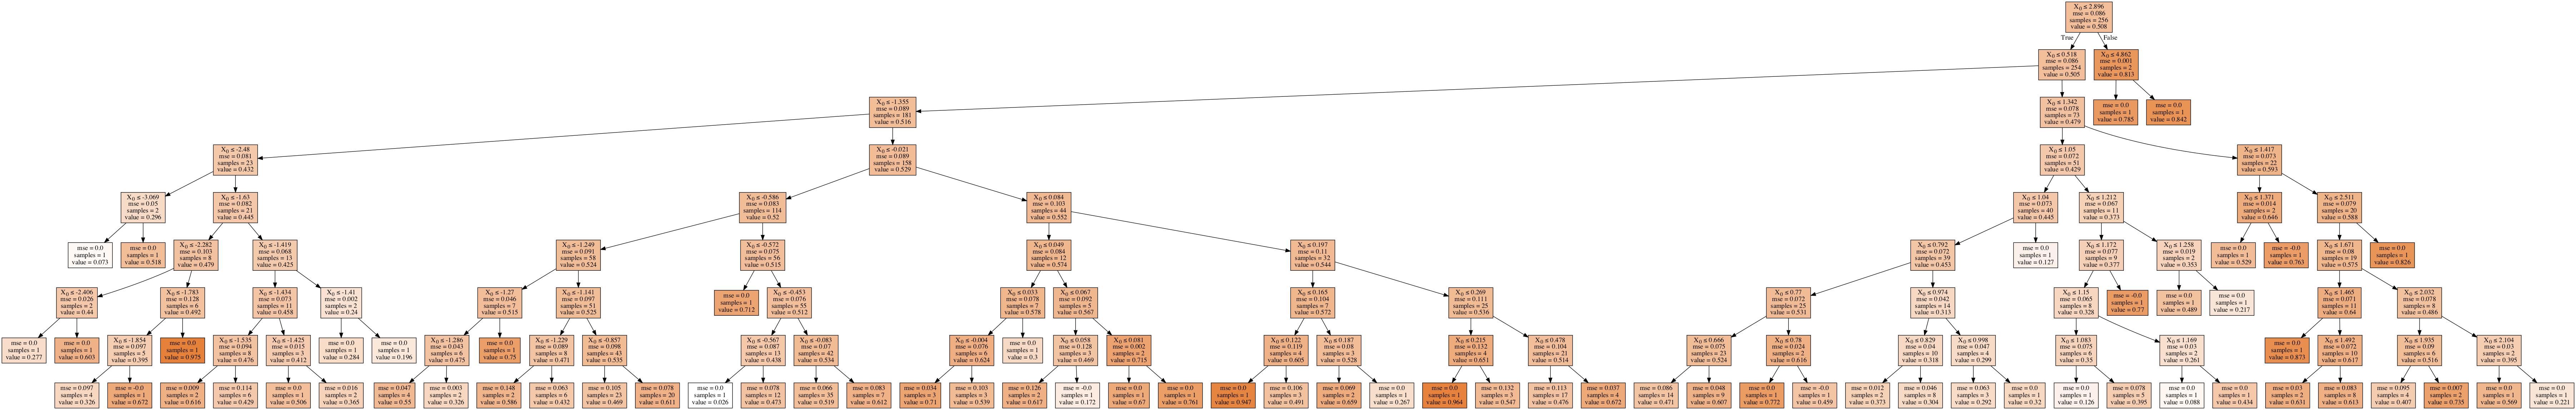

In [13]:
dot_data = StringIO()
export_graphviz(GENE_func_IF.estimators_[10], out_file=dot_data,  
                filled=True, rounded=False,
                special_characters=True, class_names=True)

#export_graphviz(GENE_func_IF.estimators_[0], out_file=dot_data, 
#                feature_names=data_feature_names,class_names=True, 
#                filled=True,rounded=True, precision=0)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue()) 
#Image(graph.write_png('./filename.png'))
Image(graph.create_png())
#graph